# Testing HTTPS vs S3 reference files for CCMP_WINDS_10M6HR_L4_V3.1

Compare performance of two reference files - one with HTTPS endpoints vs one with S3 endpoints. Reference files were created using virtualizarr with identical kwarg inputs to `open_virtual_dataset`. **This notebook assumes the reference files were already created, and are located in the same directory as this notebook as "CCMP_WINDS_10M6HR_L4_V3.1_combined-ref_s3.json" and "CCMP_WINDS_10M6HR_L4_V3.1_combined-ref_https.json".**

In [1]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

In [2]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


## 1. Function to open a data set with a virtual reference file
Uses xarray to open the data set.

In [4]:
def opends_withref(ref, fs_data, remote_protocol="s3"):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. remote_protocol can be either "s3" or "https".
    """
    storage_opts = {"fo": ref, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### 2. S3 JSON reference file

In [5]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [6]:
%%time
data = opends_withref('CCMP_WINDS_10M6HR_L4_V3.1_combined-ref_s3.json', fs)
data

CPU times: user 806 ms, sys: 104 ms, total: 910 ms
Wall time: 941 ms


<xarray.Dataset> Size: 775GB
Dimensions:    (latitude: 720, longitude: 1440, time: 46696)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [7]:
%%time

lat_range = (29, 45)
lon_range = (0, 37)
dates = xr.date_range("2020-01-01", periods=1825, unit="s")
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=dates)
data_subset

CPU times: user 911 ms, sys: 64.2 ms, total: 975 ms
Wall time: 973 ms


<xarray.Dataset> Size: 277MB
Dimensions:    (latitude: 64, longitude: 148, time: 1825)
Coordinates:
  * latitude   (latitude) float32 256B 29.12 29.38 29.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 592B 0.125 0.375 0.625 ... 36.38 36.62 36.88
  * time       (time) datetime64[ns] 15kB 2020-01-01 2020-01-02 ... 2024-12-29
Data variables:
    nobs       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [8]:
%%time
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 31.2 s, sys: 2.5 s, total: 33.7 s
Wall time: 32.8 s


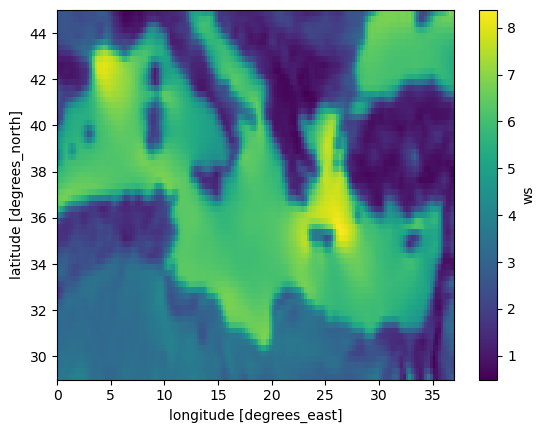

In [9]:
ws_mean_map.plot()

### 3. HTTPS JSON reference file

In [10]:
fs_https = earthaccess.get_fsspec_https_session()

In [11]:
%%time
data = opends_withref('CCMP_WINDS_10M6HR_L4_V3.1_combined-ref_https.json', fs_https, remote_protocol="https")
data

CPU times: user 25 s, sys: 651 ms, total: 25.6 s
Wall time: 42.3 s


<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [12]:
%%time

lat_range = (29, 45)
lon_range = (0, 37)
dates = xr.date_range("2020-01-01", periods=1825, unit="s")
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=dates)
data_subset

CPU times: user 801 ms, sys: 43.4 ms, total: 845 ms
Wall time: 841 ms


<xarray.Dataset> Size: 277MB
Dimensions:    (latitude: 64, longitude: 148, time: 1825)
Coordinates:
  * latitude   (latitude) float32 256B 29.12 29.38 29.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 592B 0.125 0.375 0.625 ... 36.38 36.62 36.88
  * time       (time) datetime64[ns] 15kB 2020-01-01 2020-01-02 ... 2024-12-29
Data variables:
    nobs       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [13]:
%%time
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 30.6 s, sys: 3.07 s, total: 33.7 s
Wall time: 1min


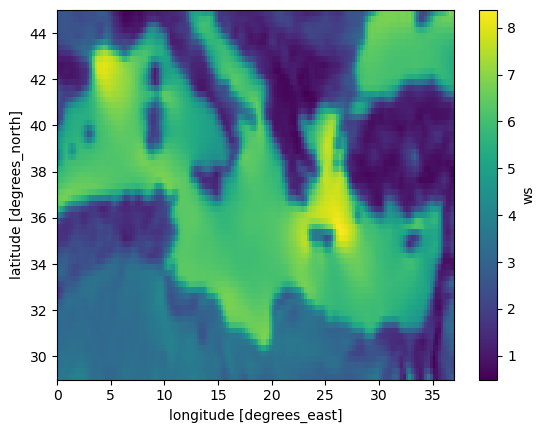

In [14]:
ws_mean_map.plot()